# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

*************

## Project Aim

In this project I aim to identify which demographic groups responds best to the different offers available. I will look at the impact of offers on average spending levels and also at the other factors that make an offer successful. Finally I will build a predictive model to evaluate the features which contribute to a successful offer.

In [1]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
# Imports
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
sns.set_theme(style='darkgrid')

In [3]:
# Useful Functions

def get_basic_info(df):   
    print("=" * 50)
    print(">> Columns: ", "{:,}".format(df.shape[1]))
    print(">> Rows   : ", "{:,}".format(df.shape[0]))
    print(">> Nulls  : ", "{:,}".format(df.isnull().sum().sum()))
    print(">> Values : ", "{:,}".format(df.notnull().sum().sum()))   
    print("=" * 50 + "\n")

## A - Initial look at the data structure

### Portfolio data

In [4]:
# First look at the portfolio data 
get_basic_info(portfolio)
portfolio.head(10)

>> Columns:  6
>> Rows   :  10
>> Nulls  :  0
>> Values :  60



,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


### Profile data

In [5]:
# Look at the profile data 
get_basic_info(profile)
profile.sample(10)

>> Columns:  5
>> Rows   :  17,000
>> Nulls  :  4,350
>> Values :  80,650



,gender,age,id,became_member_on,income
158,M,67,0f54094029ca4107bfd36203aeb3ed14,20170828,50000.0
9133,M,75,8842ff584c2847678f78f459800fea65,20180410,76000.0
764,None,118,ed46fca6de7042478b411690878dc069,20180405,NaN
9093,F,79,36e540dd327144b58b77729db6167af4,20131217,50000.0
13992,None,118,13c47585aa254c2c99abbf1fae4cac33,20131024,NaN
12838,M,67,c218177304b94ff0a0953f3ce9867870,20180609,113000.0
13746,M,76,b2ae50981e3b4884bb42b673d91bf1a2,20170618,107000.0
3065,M,31,c6d055b079a94d5599f3bfaa7666c7e6,20171121,44000.0
2864,None,118,baabcdb7520b401c89f2a26799a4e3fb,20180701,NaN
4874,F,61,f15a85e0d2f946cf8b1e6f8e99b1a72d,20180315,113000.0


<AxesSubplot:>

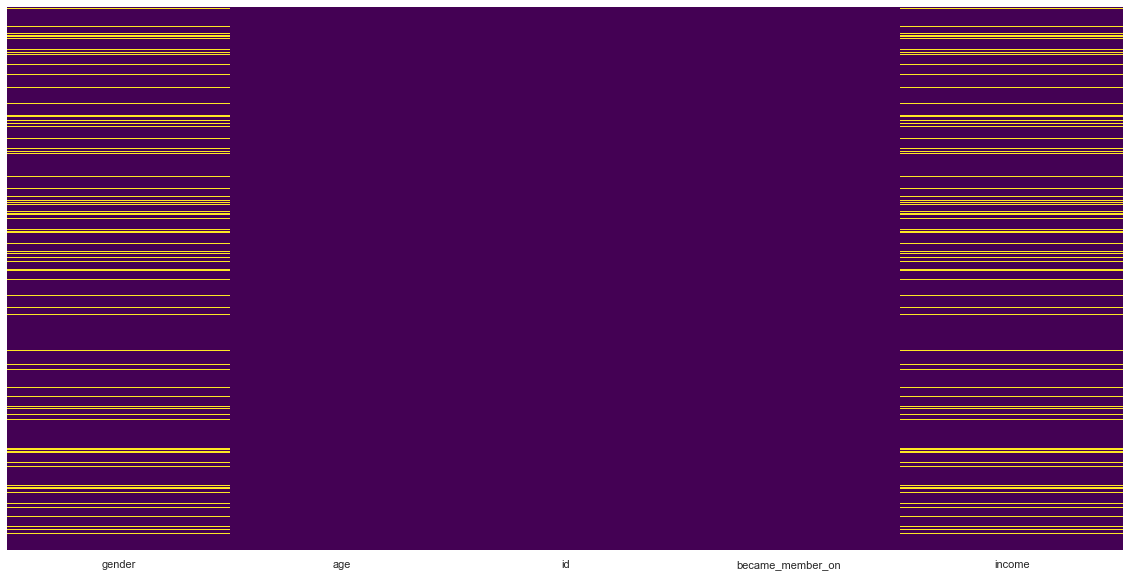

In [6]:
# visualise the nulls
plt.subplots(figsize=(20,10))
sns.heatmap(profile.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [7]:
# look at gender nulls
profile['gender'].isnull().sum()

2175

In [8]:
# look at income nulls
profile['income'].isnull().sum()

2175

In [9]:
# look at gender split
profile['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [10]:
# Look at Age split
profile['age'].describe()

count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64

In [11]:
# Look at Income
profile['income'].describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

### Transcript data

In [12]:
# First look at the transcript data 
get_basic_info(transcript)
transcript.sample(10)

>> Columns:  4
>> Rows   :  306,534
>> Nulls  :  0
>> Values :  1,226,136



,person,event,value,time
295194,47ce5043eeb2422b99445aae29a50e24,transaction,{'amount': 13.59},666
181753,77bbb4f6faf4499e8652e7879c0f314c,transaction,{'amount': 22.7},438
123478,7b32b3085ad540a58482c091b1dca914,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},336
264303,1fa42955dab44401b9f5c9a6c637e82e,offer viewed,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},582
93137,7d4b80a7ba3541f49fbccbdade389014,offer completed,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7...,240
41631,896a5bab4952449ba3c972fd71aa9f30,transaction,{'amount': 0.81},96
302996,ee8913f8d169427783b0cd1e905f304c,offer viewed,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},696
162364,d0dcec4372ca4c88955ba0ef011a8e86,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},408
244096,8efe784d3d864d1294e5d6c71af22032,transaction,{'amount': 10.07},570
105358,0622afdf88de4cb4b0b59f08312c344c,transaction,{'amount': 5.27},300


### Insights gained

#### Portfolio Data
Portfolio data contains information about 10 different offers, the underlying components (reward, difficulty, duration, type), and the channels that were used to send them to customers.

Data cleaning thoughts:
There are no nulls in the dataset. I plan to convert the id into something more meaningful and easier to read, and will split out the channels information so it can be used

#### Profile Data
The profile data contains information about the customers. 

Data cleaning thoughts:
There are nulls in the data for both income and gender and they appear on the same rows. I will probably keep unknown gender as a category, but apply the average income as a proxy for the null income values.

Age looks like it contains a default value of 118 years old. Will adjust this to the average age.

I will also calculate a "membership length" field from the became_member_from information

#### Transcript Data
The transcript data shows the transaction and offer flow by customer id, including time. 

Data cleaning thoughts:
There are no nulls in the data. The value field will need to be separated out into separate values. I will need to consider how to process the transaction / offer data to best get the information I need. 

## B - Data cleaning and processing

### Portfolio data

In [13]:
# Restructure the data 

# Apply encoding to the channels column
portfolio['channel_web'] = portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
portfolio['channel_email'] = portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
portfolio['channel_mobile'] = portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
portfolio['channel_social'] = portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)

# Apply encoding to the offer_type column
portfolio['offer_bogo'] = portfolio['offer_type'].apply(lambda x: 1 if x=='bogo' else 0)
portfolio['offer_informational'] = portfolio['offer_type'].apply(lambda x: 1 if x=='informational' else 0)
portfolio['offer_discount'] = portfolio['offer_type'].apply(lambda x: 1 if x=='discount' else 0)

# Rename id to offer_id
portfolio.rename({'id': 'offer_id'}, axis=1, inplace=True)

# Add a column to identify each offer in plain text
offer_map = {'ae264e3637204a6fb9bb56bc8210ddfd': 'bogo_1',
             '4d5c57ea9a6940dd891ad53e9dbe8da0' : 'bogo_2',
             '3f207df678b143eea3cee63160fa8bed' : 'info_1',
             '9b98b8c7a33c4b65b9aebfe6a799e6d9' : 'bogo_3',
             '0b1e1539f2cc45b7b9fa7c272da2e1d7' : 'disc_1',
             '2298d6c36e964ae4a3e7e9706d1fb8c2' : 'disc_2',
             'fafdcd668e3743c1bb461111dcafc2a4' : 'disc_3',
             '5a8bc65990b245e5a138643cd4eb9837' : 'info_2',
             'f19421c1d4aa40978ebb69ca19b0e20d' : 'bogo_4',
             '2906b810c7d4411798c6938adc9daaa5' : 'disc_4'}
portfolio['offer'] = portfolio['offer_id'].map(offer_map)



In [14]:
portfolio.sample(10)

,reward,channels,difficulty,duration,offer_type,offer_id,channel_web,channel_email,channel_mobile,channel_social,offer_bogo,offer_informational,offer_discount,offer
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,0,1,0,info_2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,0,1,disc_3
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,1,0,info_1
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0,bogo_2
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1,0,0,bogo_3
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,0,1,disc_2
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0,0,0,1,disc_4
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0,bogo_1
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,0,1,disc_1
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0,bogo_4


### Profile Data

In [15]:
# Rename id to person
profile.rename({'id': 'person'}, axis=1, inplace=True)

In [16]:
profile.sample(10)

,gender,age,person,became_member_on,income
2932,M,65,b37f326ddd0c49ae99c7d1a32512a561,20180223,94000.0
16904,F,59,3b34800e101b4f6d90ec2b2f8f969013,20170610,45000.0
5322,None,118,9d3cf2c5c0ab49f98dff4babaa56211a,20180215,NaN
2182,M,25,9a51d710fdda4b4ebba9550dcd15353c,20160528,50000.0
15295,F,70,ce7ac21bc5f84d62bbbbe793f10f42e0,20170107,106000.0
10309,M,50,73afdeca19e349b98f09e928644610f8,20160512,86000.0
3511,M,36,8cad8005c2794346a3b332db58a211e4,20180718,74000.0
14360,M,19,a83c4496729c415691adfabfb80a24db,20170818,32000.0
3354,M,45,7f1551c4db4e4c42ad75c3337b16ff70,20171029,35000.0
7414,F,47,507e271f7d2f43458ba0162db5c41b3f,20180427,60000.0


In [17]:
# Make any null Genders = U for unknown
profile['gender'] = profile['gender'].fillna('U')

# Apply one-hot encoding to the gender column
profile['M'] = profile['gender'].apply(lambda x: 1 if x=='M' else 0)
profile['F'] = profile['gender'].apply(lambda x: 1 if x=='F' else 0)
profile['O'] = profile['gender'].apply(lambda x: 1 if x=='O' else 0)
profile['U'] = profile['gender'].apply(lambda x: 1 if x=='U' else 0)

In [18]:
# Update 'became_member_on' field to datetime
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

# Use the most up to date membership as an assumed current date
assumed_current_date = profile['became_member_on'].max()
profile['member_length_days'] = assumed_current_date - profile['became_member_on']
profile['member_length_days'] = profile['member_length_days'].astype('timedelta64[D]')

In [19]:
# Deal with age = 118, which looks like a default value - set to the mean
avg_age = profile[profile['age']!=118]['age'].mean()
profile['age'] = profile['age'].apply(lambda x: avg_age if x==118 else x)


In [20]:
# Deal with missing income - set to the mean
avg_income = profile['income'].mean()
profile['income'] = profile['income'].apply(lambda x: avg_income if pd.isnull(x) else x)

#### Visualise some of the profile data
I will filter out the unknown gender data as it tends to have default values

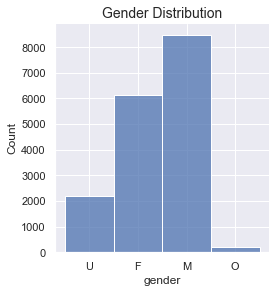

In [21]:
# Look at gender distribution
sns.displot(data = profile, x='gender', height = 4) 
plt.title('Gender Distribution', size = 14)
plt.savefig("1_gender_distribution.png", bbox_inches = 'tight')
plt.show()

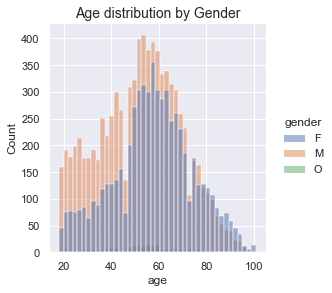

In [22]:
# Look at age distribution by gender
sns.displot(data = profile[profile['gender'] != 'U'], x='age', hue='gender', height = 4)  
plt.title('Age distribution by Gender', size = 14)
plt.savefig("2_age_distribution.png", bbox_inches = 'tight')
plt.show()

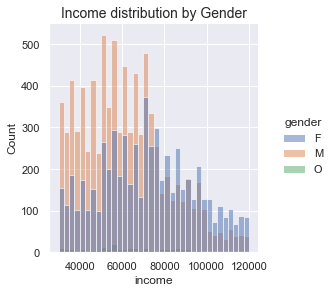

In [23]:
# Look at income distribution by gender
sns.displot(data = profile[profile['gender'] != 'U'], x='income', hue='gender', height = 4)  
plt.title('Income distribution by Gender', size = 14)
plt.savefig("3_income_distribution.png", bbox_inches = 'tight')
plt.show()

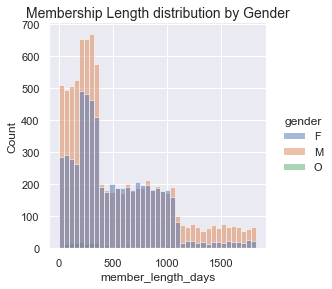

In [24]:
# Look at Membership distribution by gender
sns.displot(data = profile[profile['gender'] != 'U'], x='member_length_days', hue='gender', height = 4)  
plt.title('Membership Length distribution by Gender', size = 14)
plt.savefig("4_membership_distribution.png", bbox_inches = 'tight')
plt.show()

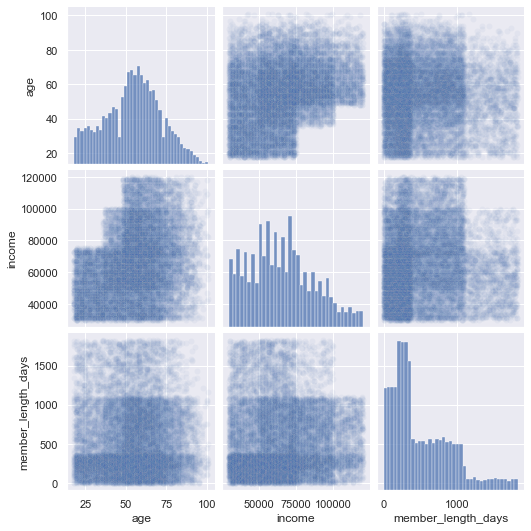

In [25]:
# Pairplot
vars=['age', 'income', 'member_length_days']
sns.pairplot(profile[profile['gender'] != 'U'], vars=vars,  plot_kws={"alpha": 0.05})

I did not think that the pairplot added any additional information above the graphs that were already shown, so did not include in the final blog

### Transcript data

In [26]:
# Separate out the offers from the value column
transcript['offer_id'] = [[*x.values()][0] if [*x.keys()][0] in ['offer id','offer_id'] else None for x in transcript.value]
transcript['offer'] = transcript['offer_id'].map(offer_map)

# Separate out the transaction values from the value column 
transcript['amount'] = [[*x.values()][0] if [*x.keys()][0] == 'amount' else 0 for x in transcript.value]

# Drop the value column
transcript.drop('value', axis=1, inplace = True)

# Add a column to aid counting
transcript['counter']=1

In [27]:
transcript.sample(10)

,person,event,time,offer_id,offer,amount,counter
95362,11fff2c68123408b93e01ea1deece057,offer viewed,252,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo_3,0.00,1
243332,eb96c54abda74fa5862e03662b0953ed,transaction,570,None,NaN,26.18,1
92609,ae42972c2f1a4c5e911a1d5f2e59bde3,transaction,240,None,NaN,1.11,1
269764,b945adc6b8ea4694afba86d644198719,offer completed,594,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo_3,0.00,1
237140,422466659dc94890a4e044633de07d39,transaction,546,None,NaN,21.69,1
47039,872e5259cef8468fb5975a3402e14176,transaction,126,None,NaN,16.57,1
19232,11fe137500b44584b5216902c274f0cb,offer viewed,12,2298d6c36e964ae4a3e7e9706d1fb8c2,disc_2,0.00,1
70215,8d8eb830eb21469a98fc037cbf5ebdcc,transaction,174,None,NaN,7.15,1
149053,aeea18cf2e8d455c98453c546292a9f6,offer viewed,402,fafdcd668e3743c1bb461111dcafc2a4,disc_3,0.00,1
61926,5ef3411586ca469b89a28e1fa38a03bd,offer received,168,2906b810c7d4411798c6938adc9daaa5,disc_4,0.00,1


In [28]:
# pick a customer at random and look at the flow of data
transcript[transcript['person']=='c3321bc76743445c9103eef0ce9d833b']

,person,event,time,offer_id,offer,amount,counter
809,c3321bc76743445c9103eef0ce9d833b,offer received,0,2298d6c36e964ae4a3e7e9706d1fb8c2,disc_2,0.00,1
12833,c3321bc76743445c9103eef0ce9d833b,offer viewed,0,2298d6c36e964ae4a3e7e9706d1fb8c2,disc_2,0.00,1
12834,c3321bc76743445c9103eef0ce9d833b,transaction,0,None,NaN,21.84,1
12835,c3321bc76743445c9103eef0ce9d833b,offer completed,0,2298d6c36e964ae4a3e7e9706d1fb8c2,disc_2,0.00,1
18219,c3321bc76743445c9103eef0ce9d833b,transaction,12,None,NaN,32.83,1
22434,c3321bc76743445c9103eef0ce9d833b,transaction,24,None,NaN,22.19,1
31196,c3321bc76743445c9103eef0ce9d833b,transaction,54,None,NaN,17.35,1
35627,c3321bc76743445c9103eef0ce9d833b,transaction,72,None,NaN,31.29,1
49569,c3321bc76743445c9103eef0ce9d833b,transaction,144,None,NaN,20.27,1
53965,c3321bc76743445c9103eef0ce9d833b,offer received,168,f19421c1d4aa40978ebb69ca19b0e20d,bogo_4,0.00,1


In [29]:
# Need to consider how to judge the success of the offers

# If the offer wasn't viewed then it can be assumed that completion of the offer was by chance

# It is also possible that the offer could be completed more than once, but do not have enough information to 
# determine the cause, so will assume that each successful person <> offer_id combination counts as one

# Pivot the data: person & offer by event
outcome = transcript.pivot_table(values = 'counter', columns = 'event',  index = ['person','offer_id'])
outcome = pd.DataFrame(outcome.to_records())

# Fill nulls with 0.0
outcome.fillna(0.0, inplace = True)

# Take the product of the two columns - if viewed and completed the value will be > 0.0
outcome['offer_success'] = outcome['offer viewed'] * outcome['offer completed']
outcome['offer_success'] = outcome['offer_success'].apply(lambda x: 1.0 if x > 0.0 else 0.0) 
outcome['offer_success_yn'] = outcome['offer_success'].apply(lambda x: 'y' if x == 1.0 else 'n') 

outcome.head(10)                 

,person,offer_id,offer completed,offer received,offer viewed,offer_success,offer_success_yn
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1.0,1.0,0.0,0.0,n
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0,1.0,1.0,0.0,n
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0,1.0,1.0,0.0,n
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1.0,1.0,1.0,1.0,y
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1.0,1.0,1.0,1.0,y
5,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,0.0,1.0,1.0,0.0,n
6,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,1.0,1.0,1.0,y
7,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1.0,1.0,1.0,1.0,y
8,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,0.0,1.0,1.0,0.0,n
9,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,0.0,1.0,1.0,0.0,n


In [30]:
outcome.shape

(63288, 7)

### Creating a transaction dataset
Create one dataset that contains all information required around the transactions

In [31]:
# Create a dataset that identifies the transactions that are attached to completed offers
# 1-select successful offers
successful_offers = outcome[outcome['offer_success']==1.0][['person', 'offer_id']]

# 2 - find times of those offers
success_times = successful_offers.merge(transcript[transcript['event']=='offer completed'], how = 'inner', on = ['offer_id','person'])
success_times = success_times[['person', 'offer', 'time']]

# 3 - if there is more than one offer at the same time will need to pick one of them (to avoid duplicating data in step 4)
success_times = success_times.groupby(['person', 'time'])['offer'].first().reset_index()

# 4 - create a dataset of transactions flagging those made at the time of successful offer completion
all_transactions = transcript[transcript['event']=='transaction'][['person', 'event', 'time', 'amount']]
all_transactions = all_transactions.merge(success_times, how='left', on=['person', 'time'])
all_transactions['offer_yn'] = all_transactions['offer'].apply(lambda x: 'n' if pd.isnull(x) else 'y') 
all_transactions['offer'] = all_transactions['offer'].apply(lambda x: 'no offer' if pd.isnull(x) else x) 

# 5 - add customer information to the transactions
tdf = all_transactions.merge(profile, how = 'inner', on = 'person')


In [32]:
tdf.head()

,person,event,time,amount,offer,offer_yn,gender,age,became_member_on,income,M,F,O,U,member_length_days
0,02c083884c7d45b39cc68e1314fec56c,transaction,0,0.83,no offer,n,F,20.0,2016-07-11,30000.0,0,1,0,0,745.0
1,02c083884c7d45b39cc68e1314fec56c,transaction,6,1.44,no offer,n,F,20.0,2016-07-11,30000.0,0,1,0,0,745.0
2,02c083884c7d45b39cc68e1314fec56c,transaction,12,4.56,no offer,n,F,20.0,2016-07-11,30000.0,0,1,0,0,745.0
3,02c083884c7d45b39cc68e1314fec56c,transaction,84,1.53,no offer,n,F,20.0,2016-07-11,30000.0,0,1,0,0,745.0
4,02c083884c7d45b39cc68e1314fec56c,transaction,90,0.50,no offer,n,F,20.0,2016-07-11,30000.0,0,1,0,0,745.0


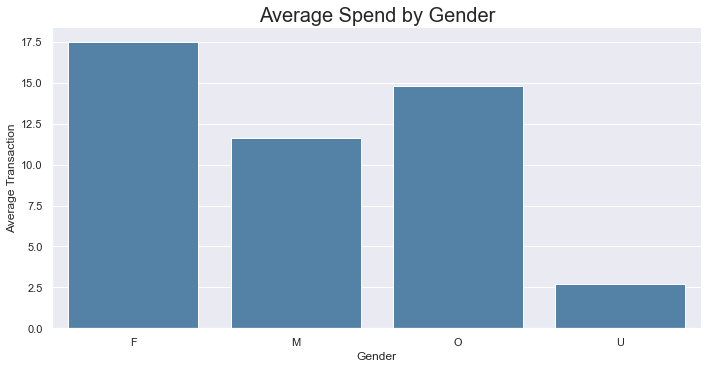

In [33]:
# What is the Average transaction rate by gender?
g_df = tdf.groupby(['gender'])['amount'].mean().reset_index()
g = sns.catplot(data=g_df, kind='bar',x='gender', y='amount', color = 'steelblue', aspect = 2)
g.set_axis_labels("Gender", "Average Transaction")
plt.title('Average Spend by Gender', size = 20)
plt.savefig("5_average_spend_by_gender.png", bbox_inches = 'tight')
plt.show()

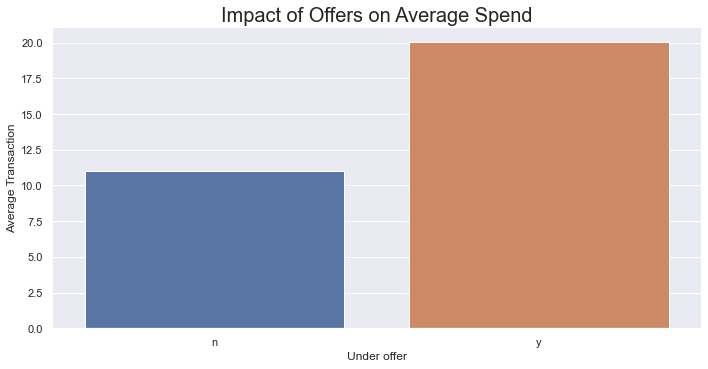

In [34]:
# What is the impact of offers on average spend?

g_df = tdf.groupby(['offer_yn'])['amount'].mean().reset_index()
g = sns.catplot(data=g_df, kind='bar',x='offer_yn', y='amount', aspect = 2)
g.set_axis_labels("Under offer", "Average Transaction")
plt.title('Impact of Offers on Average Spend', size = 20)
plt.savefig("6_impact_of_offers.png", bbox_inches = 'tight')
plt.show()

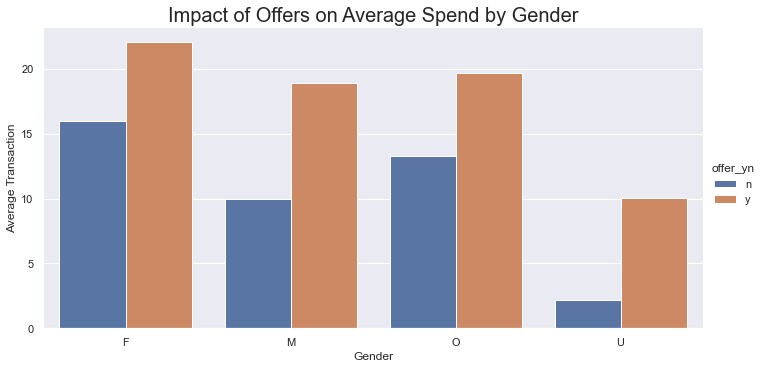

In [35]:
# What is the impact of offers on average spend and is it different by gender?

g_df = tdf.groupby(['gender','offer_yn'])['amount'].mean().reset_index()
g = sns.catplot(data=g_df, kind='bar',x='gender', y='amount', hue='offer_yn', aspect = 2)
g.set_axis_labels("Gender", "Average Transaction")
plt.title('Impact of Offers on Average Spend by Gender', size = 20)
plt.savefig("7_impact_of_offers_by_gender.png", bbox_inches = 'tight')
plt.show()

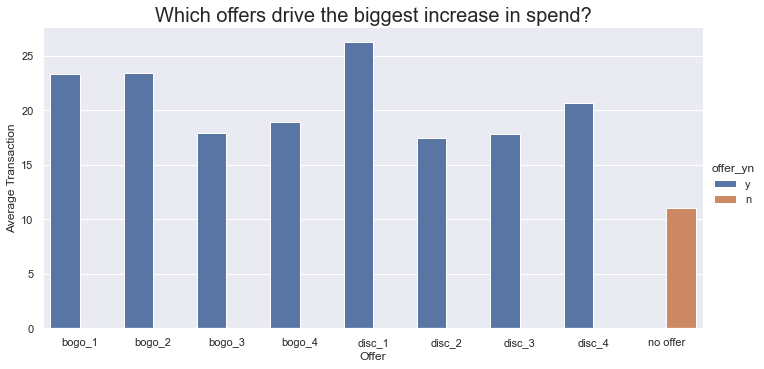

In [36]:
# Which offers drive the biggest increase in spend?

g_df = tdf.groupby(['offer','offer_yn'])['amount'].mean().reset_index()
g = sns.catplot(data=g_df, kind='bar',x='offer', y='amount', hue='offer_yn', aspect = 2)
g.set_axis_labels("Offer", "Average Transaction")
plt.title('Which offers drive the biggest increase in spend?', size = 20)
plt.savefig("8_which_offers_drive_biggest_increase.png", bbox_inches = 'tight')
plt.show()

### Creating an offer dataset
Create one dataset that contains all information required around the offers

In [37]:
# Use outcome data and add to it the offer and customer details
# Use an inner join to ensure that only transactions relating to customers kept in the dataset remain 
offer_data = outcome.merge(portfolio, how = 'inner', on = 'offer_id')
offer_data = offer_data.merge(profile, how = 'inner', on = 'person')

In [38]:
offer_data.shape

(63288, 29)

In [39]:
# Reformat the dataframe so is easier to read and drop unwanted columns
odf = offer_data[['offer_success', 'offer_success_yn', 'offer', 'age', 'gender', 'M', 'F', 'O', 'U','income', 
                  'member_length_days', 'difficulty', 'duration', 'offer_type', 'reward','offer_bogo', 
                  'offer_informational', 'offer_discount', 'channel_web', 'channel_email', 'channel_mobile', 'channel_social',
                  'offer received','offer viewed', 'offer completed']]
odf.sample(10)

,offer_success,offer_success_yn,offer,age,gender,M,F,O,U,income,...,offer_bogo,offer_informational,offer_discount,channel_web,channel_email,channel_mobile,channel_social,offer received,offer viewed,offer completed
37974,0.0,n,info_1,70.000000,M,1,0,0,0,37000.000000,...,0,1,0,1,1,1,0,1.0,1.0,0.0
24149,0.0,n,info_1,58.000000,M,1,0,0,0,52000.000000,...,0,1,0,1,1,1,0,1.0,1.0,0.0
43966,0.0,n,info_2,70.000000,M,1,0,0,0,76000.000000,...,0,1,0,0,1,1,1,1.0,0.0,0.0
20072,0.0,n,bogo_1,54.393524,U,0,0,0,1,65404.991568,...,1,0,0,0,1,1,1,1.0,1.0,0.0
47348,1.0,y,bogo_1,73.000000,F,0,1,0,0,37000.000000,...,1,0,0,0,1,1,1,1.0,1.0,1.0
36171,0.0,n,info_1,38.000000,M,1,0,0,0,45000.000000,...,0,1,0,1,1,1,0,1.0,0.0,0.0
58153,1.0,y,bogo_1,61.000000,M,1,0,0,0,31000.000000,...,1,0,0,0,1,1,1,1.0,1.0,1.0
4247,0.0,n,bogo_1,54.393524,U,0,0,0,1,65404.991568,...,1,0,0,0,1,1,1,1.0,1.0,0.0
42530,1.0,y,disc_2,80.000000,M,1,0,0,0,112000.000000,...,0,0,1,1,1,1,1,1.0,1.0,1.0
21602,1.0,y,bogo_2,58.000000,F,0,1,0,0,88000.000000,...,1,0,0,1,1,1,1,1.0,1.0,1.0


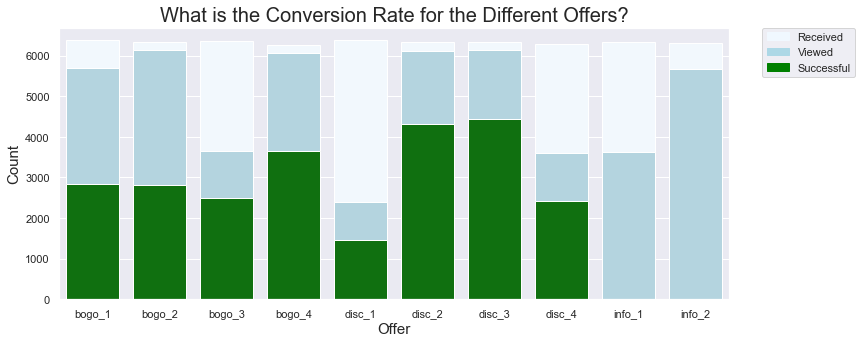

In [40]:
# What is the Conversion Rate for the different offers?

fig, axs = plt.subplots(figsize=(12,5))
sns.set_theme(style='darkgrid')

# Create the data for plot
g_df = odf.groupby(['offer'])[['offer received', 'offer viewed', 'offer_success']].sum()
g_df = pd.DataFrame(g_df.to_records())

# top bar
bar1 = sns.barplot(data = g_df, x='offer', y = 'offer received', color = 'aliceblue')

# middle bar
bar2 = sns.barplot(data = g_df, x='offer', y = 'offer viewed', color = 'lightblue')

# bottom bar
bar3 = sns.barplot(data = g_df, x='offer', y = 'offer_success', color = 'green')

# legend
top_bar = mpatches.Patch(color='aliceblue', label='Received')
middle_bar = mpatches.Patch(color='lightblue', label='Viewed')
bottom_bar = mpatches.Patch(color='green', label='Successful')

plt.legend(handles = [top_bar, middle_bar, bottom_bar], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("Offer", size = 15)
plt.ylabel("Count", size = 15)
plt.title("What is the Conversion Rate for the Different Offers?", size = 20)
plt.savefig("9_what_is_the_conversion_rate_of_offers.png", bbox_inches = 'tight')
plt.show()


In [41]:
# Create a dataset to look at the percentage results per offer 
p_df = odf.groupby(['offer'])[['offer received', 'offer viewed', 'offer_success']].sum()
p_df = pd.DataFrame(p_df.to_records())
# remove info offers as we can't measure their success
p_df = p_df[p_df['offer_success'] > 0]
# calculate percentages
p_df['view_percent'] = p_df['offer viewed'] / p_df['offer received']
p_df['success_percent'] = p_df['offer_success'] / p_df['offer viewed']
# add back the underlying offer information
p_df = p_df.merge(portfolio, on='offer', how='inner')
p_df.drop(['offer_id','offer_informational'], axis=1, inplace = True)

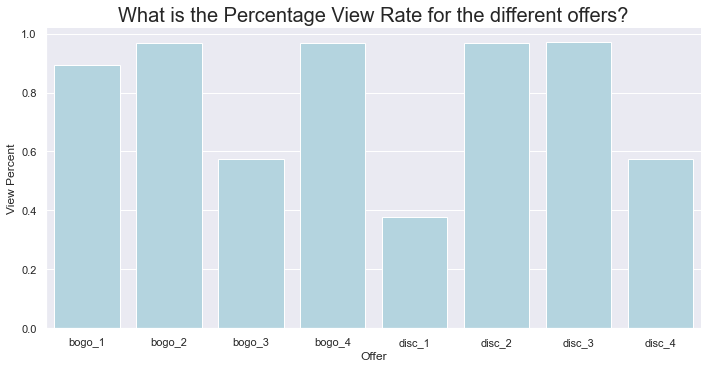

In [42]:
# What is the Percentage Conversion Rate for the different offers?

g = sns.catplot(data=p_df, kind='bar',x='offer', y='view_percent', color = 'lightblue',aspect = 2)
g.set_axis_labels("Offer", "View Percent")
plt.title('What is the Percentage View Rate for the different offers?', size = 20)
plt.savefig("10_percentage_view.png", bbox_inches = 'tight')
plt.show()


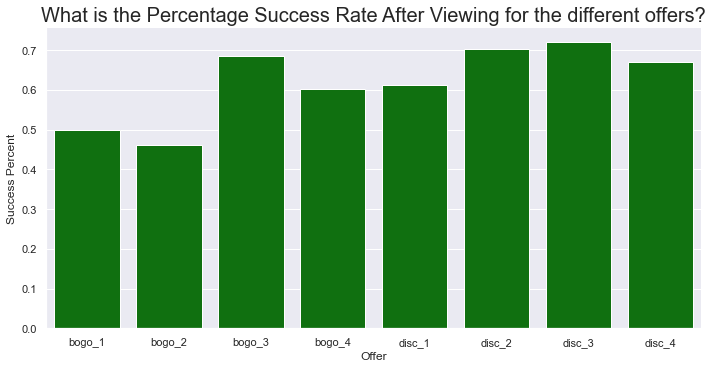

In [43]:
# What is the Percentage Conversion Rate for the different offers?

g = sns.catplot(data=p_df, kind='bar',x='offer', y='success_percent', color = 'green',aspect = 2)
g.set_axis_labels("Offer", "Success Percent")
plt.title('What is the Percentage Success Rate After Viewing for the different offers?', size = 20)
plt.savefig("11_percentage_success.png", bbox_inches = 'tight')
plt.show()

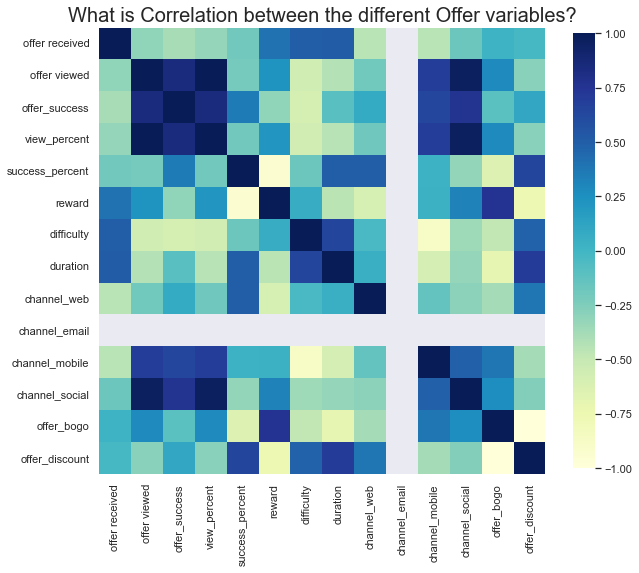

In [44]:
plt.figure(figsize=(10,10))
sns.heatmap(p_df.corr(),square=True, cmap='YlGnBu', cbar_kws={"shrink": 0.8})
plt.title("What is Correlation between the different Offer variables?", size = 20)
plt.savefig("12_correlation.png", bbox_inches = 'tight')
plt.show()

In [45]:
portfolio[['offer', 'channels','channel_web', 'channel_email', 
           'channel_mobile','channel_social']].sort_values('offer', ascending=True)

,offer,channels,channel_web,channel_email,channel_mobile,channel_social
0,bogo_1,"[email, mobile, social]",0,1,1,1
1,bogo_2,"[web, email, mobile, social]",1,1,1,1
3,bogo_3,"[web, email, mobile]",1,1,1,0
8,bogo_4,"[web, email, mobile, social]",1,1,1,1
4,disc_1,"[web, email]",1,1,0,0
5,disc_2,"[web, email, mobile, social]",1,1,1,1
6,disc_3,"[web, email, mobile, social]",1,1,1,1
9,disc_4,"[web, email, mobile]",1,1,1,0
2,info_1,"[web, email, mobile]",1,1,1,0
7,info_2,"[email, mobile, social]",0,1,1,1


## Modelling
## Is it possible to build a model to predict success of an Offer?

In [46]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

### Model data preparation

In [47]:
offer_data.columns

Index(['person', 'offer_id', 'offer completed', 'offer received',
       'offer viewed', 'offer_success', 'offer_success_yn', 'reward',
       'channels', 'difficulty', 'duration', 'offer_type', 'channel_web',
       'channel_email', 'channel_mobile', 'channel_social', 'offer_bogo',
       'offer_informational', 'offer_discount', 'offer', 'gender', 'age',
       'became_member_on', 'income', 'M', 'F', 'O', 'U', 'member_length_days'],
      dtype='object')

In [48]:
# dataset for model
X_df =  offer_data[offer_data['offer_informational']==0][['offer_success', 'age', 'M', 'F', 'O', 'U','income', 
                                                          'member_length_days','difficulty', 'duration', 'reward', 
                                                          'channel_web', 'channel_email', 'channel_mobile', 'channel_social',
                                                          'offer_bogo','offer_discount']]

y_df = X_df.pop('offer_success')

In [49]:
# Feature Scaling
def scale_features(df, features):
    '''
    Function to scale a given list of features in a dataframe

    INPUT:
    df - dataframe
    feat - list of features (columns) in dataframe to scale
    
    OUTPUT:
    df_scaled - scaled dataframe
    '''
    
    # Select only the features to scale
    df_features_to_scale = df[features]

    # Apply feature scaling
    scaler = MinMaxScaler()
    df_features_to_scale = pd.DataFrame(scaler.fit_transform(df_features_to_scale), 
                                        columns = df_features_to_scale.columns, index=df_features_to_scale.index)

    # Drop original features from df and then add back on the scaled features 
    df = df.drop(columns=features, axis=1)
    df_scaled = pd.concat([df, df_features_to_scale], axis=1)

    return df_scaled

In [50]:
# Apply feature scaling to selected fields 
features_to_scale =  ['age','income','member_length_days','difficulty', 'duration', 'reward']
scaled_X_df = scale_features(X_df, features_to_scale)

### Try three different models
1 - Logistic Regression

2 - Random Forest

3 - Adaboost

In [51]:
def test_model(X, y, model):
    '''
    Generic Regression Classifier model
    
    INPUT:
    X - model inputs
    y - the target value
    model - the model to test
    
    OUTPUT:
    model - the classification model
    
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=1)
    model.fit(X_train, y_train)
    model_predictions = model.predict(X_test)
    print(classification_report(y_test, model_predictions))
    print("Overall model accuracy:\t {}".format(accuracy_score(y_test, model_predictions)))
    
    train_probs = model.predict_proba(X_train)
    model_probs = model.predict_proba(X_test)
    print("Train ROC AUC score:\t {}".format(roc_auc_score(y_train, train_probs[:, 1])))
    print("Test ROC AUC score:\t {}".format(roc_auc_score(y_test, model_probs[:, 1])))
    
    return model

In [52]:
# Run the Logistic Regression Model
clf = LogisticRegression(max_iter=1000, random_state=1) 
lr_model = test_model(scaled_X_df, y_df, clf)
# Note - scaled features used for the logistic regression model
#        but not required for random forest and adaboost

              precision    recall  f1-score   support

         0.0       0.70      0.70      0.70      7875
         1.0       0.68      0.69      0.68      7317

    accuracy                           0.69     15192
   macro avg       0.69      0.69      0.69     15192
weighted avg       0.69      0.69      0.69     15192

Overall model accuracy:	 0.6904291732490785
Train ROC AUC score:	 0.7735353373293703
Test ROC AUC score:	 0.7664424443186231


In [53]:
# Run the Random Forest Regression Model
clf = RandomForestClassifier(random_state=1) 
rf_model = test_model(X_df, y_df, clf)

              precision    recall  f1-score   support

         0.0       0.70      0.71      0.70      7875
         1.0       0.68      0.68      0.68      7317

    accuracy                           0.69     15192
   macro avg       0.69      0.69      0.69     15192
weighted avg       0.69      0.69      0.69     15192

Overall model accuracy:	 0.693127962085308
Train ROC AUC score:	 0.9997581299979532
Test ROC AUC score:	 0.7687308919650044


In [54]:
# Run the AdaBoost Regression Model
clf = AdaBoostClassifier(random_state=1)  
ada_model = test_model(X_df, y_df, clf)

              precision    recall  f1-score   support

         0.0       0.72      0.73      0.73      7875
         1.0       0.71      0.70      0.70      7317

    accuracy                           0.72     15192
   macro avg       0.71      0.71      0.71     15192
weighted avg       0.71      0.72      0.71     15192

Overall model accuracy:	 0.715047393364929
Train ROC AUC score:	 0.8009054187288395
Test ROC AUC score:	 0.7927887177284472


### Insight:

From the three models it appears that the adaboost model is performing the best.

It may be possible to improve the results with parameter tuning

In [55]:
ada_model.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': 1}

In [56]:
param_grid={'n_estimators': [25, 50, 100, 200],
            'learning_rate': [0.1,0.7, 1, 1.5, 2.0]}

cv = GridSearchCV(ada_model, param_grid=param_grid, scoring = 'roc_auc')

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size = 0.3, random_state=1)
score = cv.fit(X_train, y_train)
score.best_params_


{'learning_rate': 1, 'n_estimators': 100}

In [57]:
# Final model using the best parameters
clf = AdaBoostClassifier(learning_rate = 1, n_estimators = 100, random_state=1)  
final_model = test_model(X_df, y_df, clf)

              precision    recall  f1-score   support

         0.0       0.72      0.73      0.73      7875
         1.0       0.71      0.70      0.70      7317

    accuracy                           0.71     15192
   macro avg       0.71      0.71      0.71     15192
weighted avg       0.71      0.71      0.71     15192

Overall model accuracy:	 0.7141916798314902
Train ROC AUC score:	 0.8018055141311881
Test ROC AUC score:	 0.7930847797366862


### Insight: 
The grid search adaboost model performs almost identically as the adaboost model with the default parameters


### Look at feature importance

In [58]:
feature_importance = pd.DataFrame(final_model.feature_importances_, index=X_df.columns, 
                        columns=['importance']).sort_values('importance', ascending=False).reset_index()
feature_importance

,index,importance
0,member_length_days,0.35
1,income,0.20
2,age,0.16
3,duration,0.07
4,difficulty,0.04
5,reward,0.04
6,U,0.02
7,channel_web,0.02
8,channel_mobile,0.02
9,channel_social,0.02


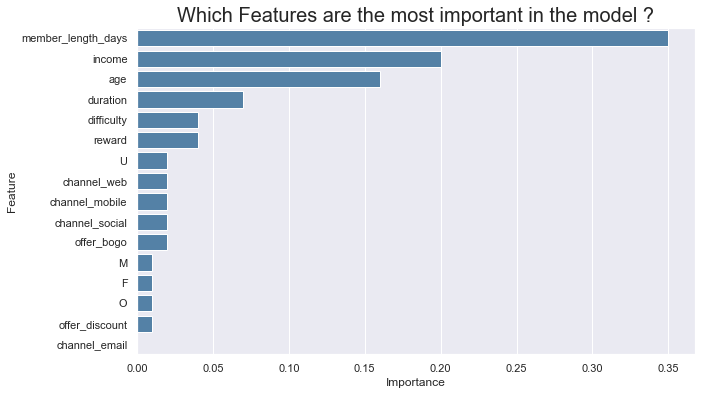

In [59]:
# What is the Percentage Conversion Rate for the different offers?
f, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='index', color = 'steelblue')
ax.set(ylabel="Feature", xlabel="Importance")
plt.title('Which Features are the most important in the model ?', size = 20)
plt.savefig("16_feature_importance.png", bbox_inches = 'tight')
plt.show()

## Reflections and Summary
In this project I set out to analyse the data provided and draw useful insight from it.
I have been able to show different views of the data and provide useful information that would be commercially valuable for understanding the success of offers made, and their corresponding impact on customer spend. 


In particular the impact of media channel on success of an offer is one insight that is easy to address. The impact of offers on average spend is also worth calling out. I am certain that more detailed analysis could be done in this space and with additional data could be even more compelling. 


I was pleased with the results obtained from the final model and think that an accuracy of 71% is fairly decent for this type of problem. With more time I would have liked to explore and refine the predictive model and test alternative modelling approaches.  

In addition to predicting success of offers I think that a recommender model would be particularly useful to develop.


Overall this project has been challenging. There is a lot of data manipulation and that has taken some time to navigate. I am also much more proficient with the use of the Seaborn add-ins having completed this project.